In [17]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import the code from Afresh

In [7]:
# Clearly, this problem needs order_cost < under_order_cost , otherwise we’ll never order cereal.

## TODO: MYPY!

def get_cost(inventory, order, order_cost= 2, over_order_cost=4, under_order_cost=5):
    over_order_cost = max(inventory, 0) * over_order_cost
    under_order_cost = -min(inventory, 0) * under_order_cost
    return over_order_cost + under_order_cost + order * order_cost

def act_and_get_cost(inventory, order, demand):
    # possibly negative  
    resulting_inventory = inventory + order - demand
    cost = get_cost(inventory, order)
    next_inventory = max(resulting_inventory, 0)
    return next_inventory, cost

In [9]:
act_and_get_cost(10, 5, 1)

(14, 50)

In [54]:


class NonPerishableDPSolver:
    def __init__(self,
                 over_order_cost: float,
                 under_order_cost: float,
                 fixed_order_cost: float):
        self.over_order_cost = over_order_cost
        self.under_order_cost = under_order_cost
        self.fixed_order_cost = fixed_order_cost

    def cost_function(self, state, order):
        over_order_cost = max(state, 0) * self.over_order_cost
        under_order_cost = -min(state, 0) * self.under_order_cost
        order_cost = self.fixed_order_cost * order
        return over_order_cost + under_order_cost + order_cost

    def act(self, state: float, shipment: float, sales: float) -> Tuple[float, float]:
        resulting_state = state + shipment - sales
        cost = self.cost_function(resulting_state, shipment)
        resulting_state = max(resulting_state, 0)
        return resulting_state, cost
    
    def dp_solve(self, forecasts: np.array):
        T = forecasts.shape[0] # these are days
        max_order = forecasts.shape[1] # forecasts are the probability of that order being made, each col is an order amount
        print(max_order, 'max_order')
        
        inventory_max = max_order * (T + 1)
        print(inventory_max, 'inventory_max')
        inventory_max_opt = max_order * T
        print(inventory_max_opt, 'inventory_max_opt')
        
        matrix_size = (T + 1, inventory_max)
        
        explain_array = np.zeros((T + 1, inventory_max, max_order))
        path_array = np.full(matrix_size, -1, dtype=np.int32)
        cost_array = np.full(matrix_size, np.inf)
        cost_array[-1, :] = 0
        
        for t in range(T - 1, -1, -1):
            print(t, 'T')
            for inv in range(inventory_max_opt):
                best_order = -1
                best_cost = np.inf
                for order in range(max_order):
                    cost = 0
                    for forecast in range(max_order): #
                        forecast_prob = forecasts[t, forecast]
                        # forecast here is used as shipment
                        state, prob_cost = self.act(inv, order, forecast)
                        resultant_cost = cost_array[t + 1, state]
                        cost += forecast_prob * (prob_cost + resultant_cost)
                    explain_array[t, inv, order] = cost
                    if cost < best_cost:
                        best_cost = cost
                        best_order = order
                path_array[t, inv] = best_order
                cost_array[t, inv] = best_cost
        return explain_array, path_array, cost_array

In [132]:
# 10 days of forecasts, 15 possible values
forecasts_unnormalized = np.random.random((10, 15))
# Normalize to make probabilities:
# This is used for the percent of total inventory that is demanded
forecasts = forecasts_unnormalized / np.expand_dims(forecasts_unnormalized.sum(axis=1), 1)
# Solve
solver = NonPerishableDPSolver(over_order_cost=2,under_order_cost= 6, fixed_order_cost=0)

# path_array, optimal order in this state
# cost array, cost in this state
explain_array, path_array, cost_array = solver.dp_solve(forecasts)

15 max_order
165 inventory_max
150 inventory_max_opt
9 T
8 T
7 T
6 T
5 T
4 T
3 T
2 T
1 T
0 T


In [27]:
cost_array.shape # why is there 11 here?

(11, 165)

In [28]:
forecasts.shape

(10, 15)

In [29]:
path_array.shape

(11, 165)

## Forecasts

Text(0.5, 0.98, 'Inventory Count at time zero')

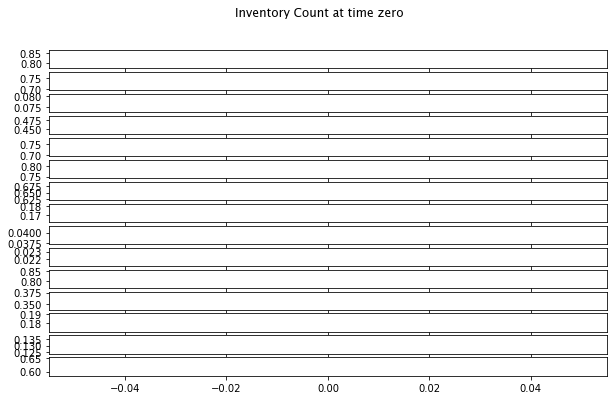

In [135]:
fig, ax = plt.subplots( len(forecasts[0,:]), squeeze=True, figsize=(10,6))

for inventory_count in range(len(forecasts_unnormalized[0, :])): # x is day, y is inventory
    ax[inventory_count].plot(forecasts_unnormalized[0, inventory_count])
fig.suptitle('Inventory Count at time zero') 

    



## Cost

In [78]:
cost_array.shape

(11, 165)

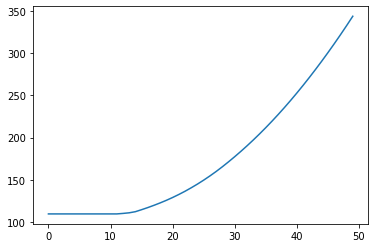

In [100]:
plt.plot(cost_array[0, :50])

Text(0.5, 0.98, 'Cost per day. each plot is a day, x axis is cost')

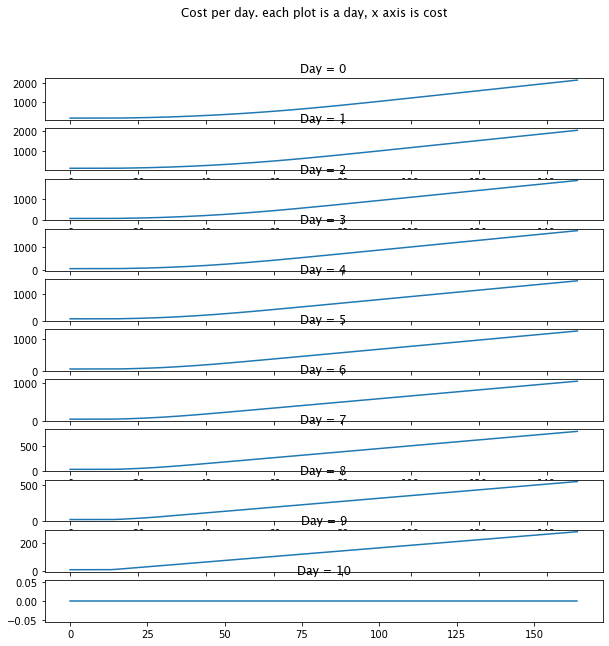

In [109]:
n_days =  cost_array.shape[0]
fig, ax = plt.subplots(n_days, squeeze=True, figsize=(10,10)) # x axis is day, y axis is inventory

for day_n in range(n_days):
    ax[day_n].plot(cost_array[day_n, :])
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[day_n].set_title(f"Day = {day_n}")

fig.suptitle('Cost per day. each plot is a day, x axis is cost') 
    



In [ ]:
## at T=

### Path

In [87]:
path_array.shape

(11, 165)

Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

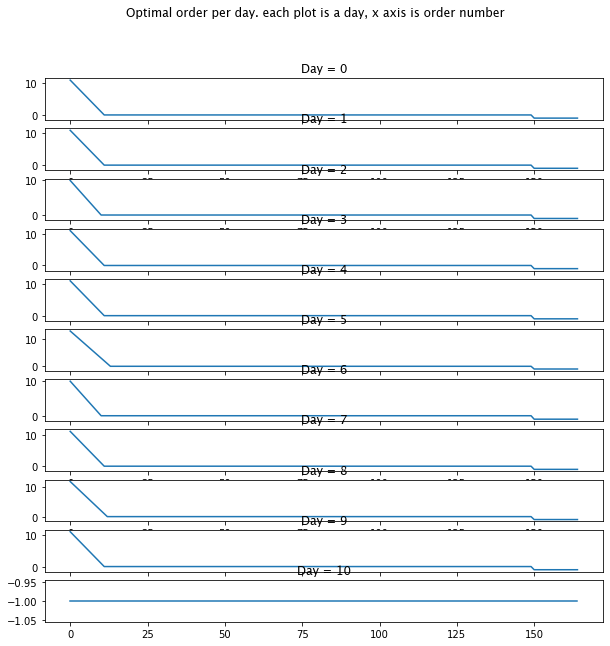

In [121]:
n_days =  path_array.shape[0]
fig, ax = plt.subplots(n_days, squeeze=True, figsize=(10,10)) # x axis is day, y axis is inventory

for day_n in range(n_days):
    ax[day_n].plot(path_array[day_n, :])
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[day_n].set_title(f"Day = {day_n}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



## Path vs Cost

### Explain Array

In [139]:
explain_array.shape # Time, Inventory, Order

(11, 165, 15)

Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

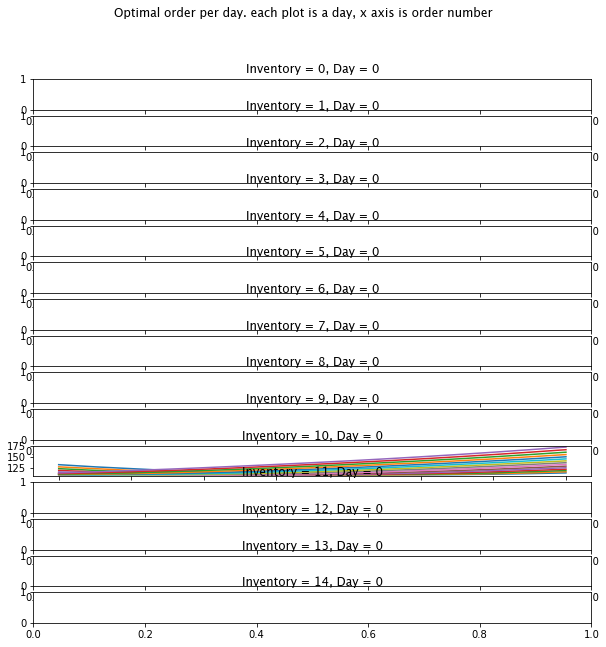

In [140]:
inventory_n =  15 # explain_array.shape[1]
fig, ax = plt.subplots(inventory_n, squeeze=True, figsize=(10,10)) # x axis is day, y axis is inventory

for inventory in range(inventory_n):
    ax[day_n].plot(explain_array[0, inventory, :])
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = 0")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    

